In [255]:
import time
import copy
import numpy as np
from skimage.filters import gaussian
import cv2

import matplotlib.pyplot as plt
import pylab as pl

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

from tifffile import imread, imsave
import cPickle as pickle

%reload_ext autoreload
%autoreload 2

from netsurface2d import NetSurf2d
from netsurface2dt import NetSurf2dt
from data3d import Data3d
import bresenham as bham

Populating the interactive namespace from numpy and matplotlib


In [256]:
folder = '/Users/jug/Repositories/GIT/BobSeg/export/'
flow = imread(folder+'flow.tiff')
stack = imread(folder+'stack.tiff')

segchannel = stack[:,1,:,:]
flowchannel = stack[:,0,:,:]
sigma = [0.,2.,2.]
segchannel_smooth = gaussian(segchannel,sigma)

flow_x = np.swapaxes(flow,0,1)[0]
flow_y = np.swapaxes(flow,0,1)[1]

print shape(stack)
assert shape(stack) == shape(flow)

(50, 2, 595, 403)


In [257]:
# fake flow images that can be used to test kymograph plots below
ffline = range(542)
ff = [ffline] * 919
ff = np.array(ff).T
#imshow(ff)

In [265]:
line_x1 = 180
line_y1 = 350
line_x2 = 180
line_y2 = 180
line = (line_x1,line_y1,line_x2,line_y2)
line_length = math.sqrt( (line_x1-line_x2)**2 + (line_y1-line_y2)**2)
print 'line length: '+str(line_length)
line_pixels = bham.bresenhamline(np.array([(line_x1,line_y1)]),np.array([(line_x2,line_y2)]))
print 'bresenham line length: '+str(len(line_pixels))

line length: 170.0
bresenham line length: 170


In [266]:
shape(flow)

(50, 2, 595, 403)

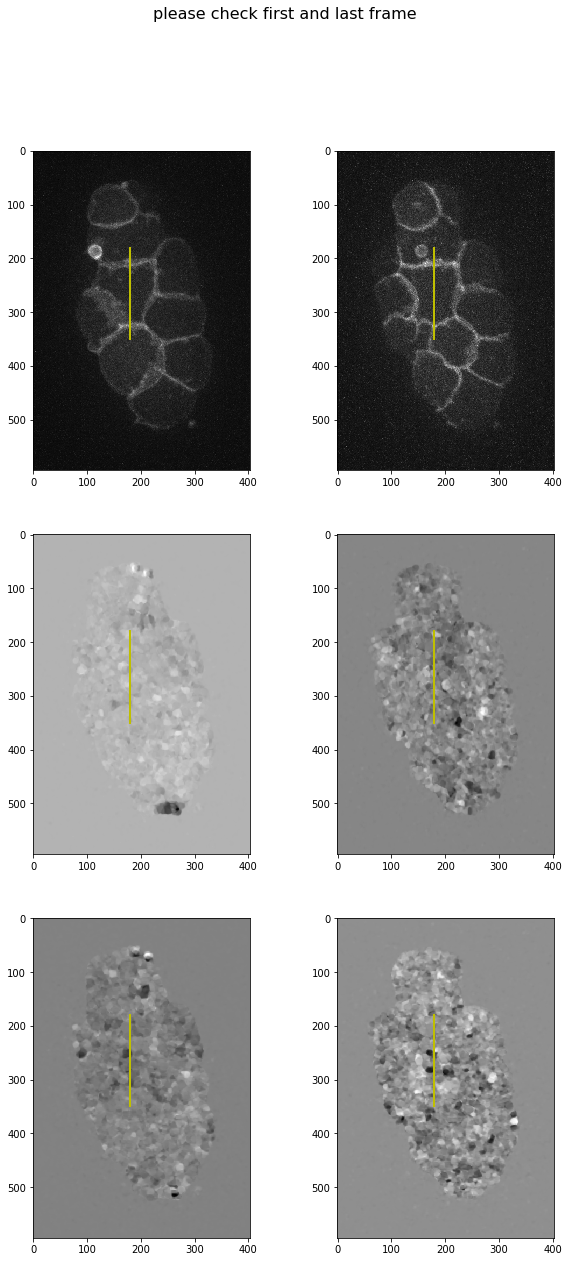

In [267]:
pylab.rcParams['figure.figsize'] = (10, 20)
fig = plt.figure()
fig.suptitle('please check first and last frame', fontsize=16)
ax = fig.add_subplot(321)
ax.imshow(segchannel[0], plt.get_cmap('gray'))
ax.plot([line_x1,line_x2],[line_y1,line_y2],'y-',lw=2)
ax = fig.add_subplot(322)
ax.imshow(segchannel[-1], plt.get_cmap('gray'))
ax.plot([line_x1,line_x2],[line_y1,line_y2],'y-',lw=2)

ax = fig.add_subplot(323)
ax.imshow(flow_x[1], plt.get_cmap('gray'))
ax.plot([line_x1,line_x2],[line_y1,line_y2],'y-',lw=2)
ax = fig.add_subplot(324)
ax.imshow(flow_x[-1], plt.get_cmap('gray'))
ax.plot([line_x1,line_x2],[line_y1,line_y2],'y-',lw=2)

ax = fig.add_subplot(325)
ax.imshow(flow_y[1], plt.get_cmap('gray'))
ax.plot([line_x1,line_x2],[line_y1,line_y2],'y-',lw=2)
ax = fig.add_subplot(326)
ax.imshow(flow_y[-1], plt.get_cmap('gray'))
ax.plot([line_x1,line_x2],[line_y1,line_y2],'y-',lw=2)

In [296]:
def get_projected_length(line,flow_x,flow_y):
    ldx = line[2]-line[0]
    ldy = line[3]-line[1]
    len_line = math.sqrt(ldx**2+ldy**2)
    return (flow_x*ldx + flow_y*ldy)/len_line
    #return flow_x+flow_y

def get_pixel_values(image, coords):
    values = []
    for c in coords:
        values.append(image[c[1]][c[0]])
    return values

def move_marker(pos,flow_kymo):
    markers = [pos]
    for col in range(1,len(stack)):
        pos += flow_kymo[int(round(pos)),col]
        markers.append(pos)
    return markers

In [297]:
kymo_intensity = np.zeros((len(line_pixels),len(stack)))
kymo_projflow = np.zeros((len(line_pixels),len(stack)))
for col in range(len(stack)):
    fx = get_pixel_values(flow_x[col], line_pixels)
    fy = get_pixel_values(flow_y[col], line_pixels)
    for row in range(len(line_pixels)):
        x = line_pixels[row][0]
        y = line_pixels[row][1]
        kymo_intensity[row,col] = segchannel[col,y,x]
        kymo_projflow[row,col] = get_projected_length(line,fx[row],fx[row])

In [298]:
marker1 = move_marker(40,kymo_projflow)
marker2 = move_marker(120,kymo_projflow)

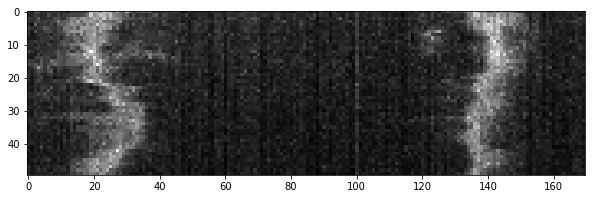

In [299]:
imshow(kymo_intensity.T, plt.get_cmap('gray'))

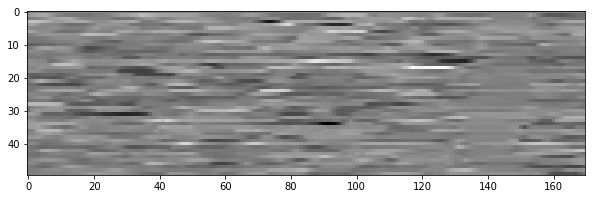

In [300]:
imshow(kymo_projflow.T, plt.get_cmap('gray'))

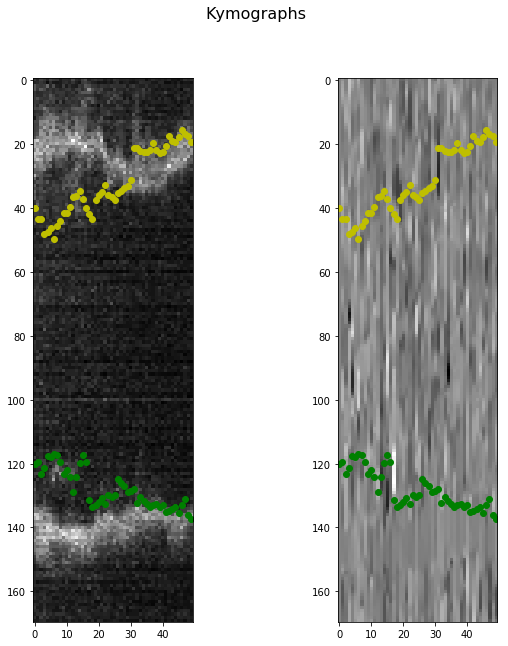

In [301]:
pylab.rcParams['figure.figsize'] = (10, 10)
fig = plt.figure()
fig.suptitle('Kymographs', fontsize=16)
ax = fig.add_subplot(121)
ax.imshow(kymo_intensity, plt.get_cmap('gray'))
ax.plot(marker1, 'yo')
ax.plot(marker2, 'go')

ax = fig.add_subplot(122)
ax.imshow(kymo_projflow, plt.get_cmap('gray'))
ax.plot(marker1, 'yo')
ax.plot(marker2, 'go')